In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from PyKomoran import *
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow_text
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

In [2]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
#text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilkobert_cased_preprocess/1")
#encoder_inputs = preprocessor(text_input)

2022-11-06 04:56:55.939840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 04:56:56.747755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 513 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6


In [4]:
def build_classifier_model():
    
    input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
    
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilkobert_cased_preprocess/1")
    
    processing_input = preprocessing_layer(input_text)
    
    encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilkobert_cased_L-3_H-768_A-12/1", trainable=True)
    
    encoded = encoder(processing_input)
    
    net = encoded['pooled_output']
    
    x = Dropout(0.1)(net)
    x = Dense(256, activation="relu", name='Dense1')(x)
    x = Dense(128, activation="relu", name='Dense2')(x)
    x = Dense(46, activation="softmax", name='classifier')(x)
    output = x
    
    return tf.keras.Model(input_text, output)

In [5]:
df_train = pd.read_csv("./train.csv").fillna("NAN")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174304 entries, 0 to 174303
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   index      174304 non-null  int64 
 1   제출년도       174304 non-null  int64 
 2   사업명        174304 non-null  object
 3   사업_부처명     174304 non-null  object
 4   계속과제여부     174304 non-null  object
 5   내역사업명      174304 non-null  object
 6   과제명        174304 non-null  object
 7   요약문_연구목표   174304 non-null  object
 8   요약문_연구내용   174304 non-null  object
 9   요약문_기대효과   174304 non-null  object
 10  요약문_한글키워드  174304 non-null  object
 11  요약문_영문키워드  174304 non-null  object
 12  label      174304 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 17.3+ MB


In [6]:
df_test = pd.read_csv("./test.csv").fillna("NAN")

In [7]:
x_train = df_train["사업명"] + " " + df_train["과제명"] + " " + df_train["요약문_연구목표"] + " " + df_train["요약문_연구내용"] + " " + df_train["요약문_기대효과"] + df_train["요약문_한글키워드"]
y_train = df_train["label"].values

In [8]:
y_train = to_categorical(y_train)
y_train.shape

(174304, 46)

In [9]:
values = df_train["label"].value_counts()

In [10]:
for i in range(46):
    print(f'{i}: {values[i]}개')

0: 142571개
1: 1261개
2: 275개
3: 143개
4: 57개
5: 1698개
6: 78개
7: 113개
8: 339개
9: 106개
10: 658개
11: 200개
12: 268개
13: 575개
14: 1672개
15: 165개
16: 506개
17: 154개
18: 1550개
19: 4938개
20: 1059개
21: 496개
22: 148개
23: 1840개
24: 3520개
25: 810개
26: 316개
27: 620개
28: 449개
29: 1028개
30: 234개
31: 922개
32: 260개
33: 533개
34: 523개
35: 291개
36: 1060개
37: 266개
38: 262개
39: 202개
40: 441개
41: 67개
42: 51개
43: 351개
44: 91개
45: 1137개


In [23]:
from matplotlib import font_manager, rc
path = './NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()

rc('font', family=font_name)
print(font_name)

fontprop = font_manager.FontProperties(fname=path, size=12)

NanumGothic


In [44]:
plt.rcParams["font.family"] = "NanumGothic"

In [42]:
plt.rc('font', family='NanumGothic') # 폰트 설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷
%matplotlib inline  
warnings.filterwarnings('ignore')

<AxesSubplot:title={'center':'test 사업_부처별'}>

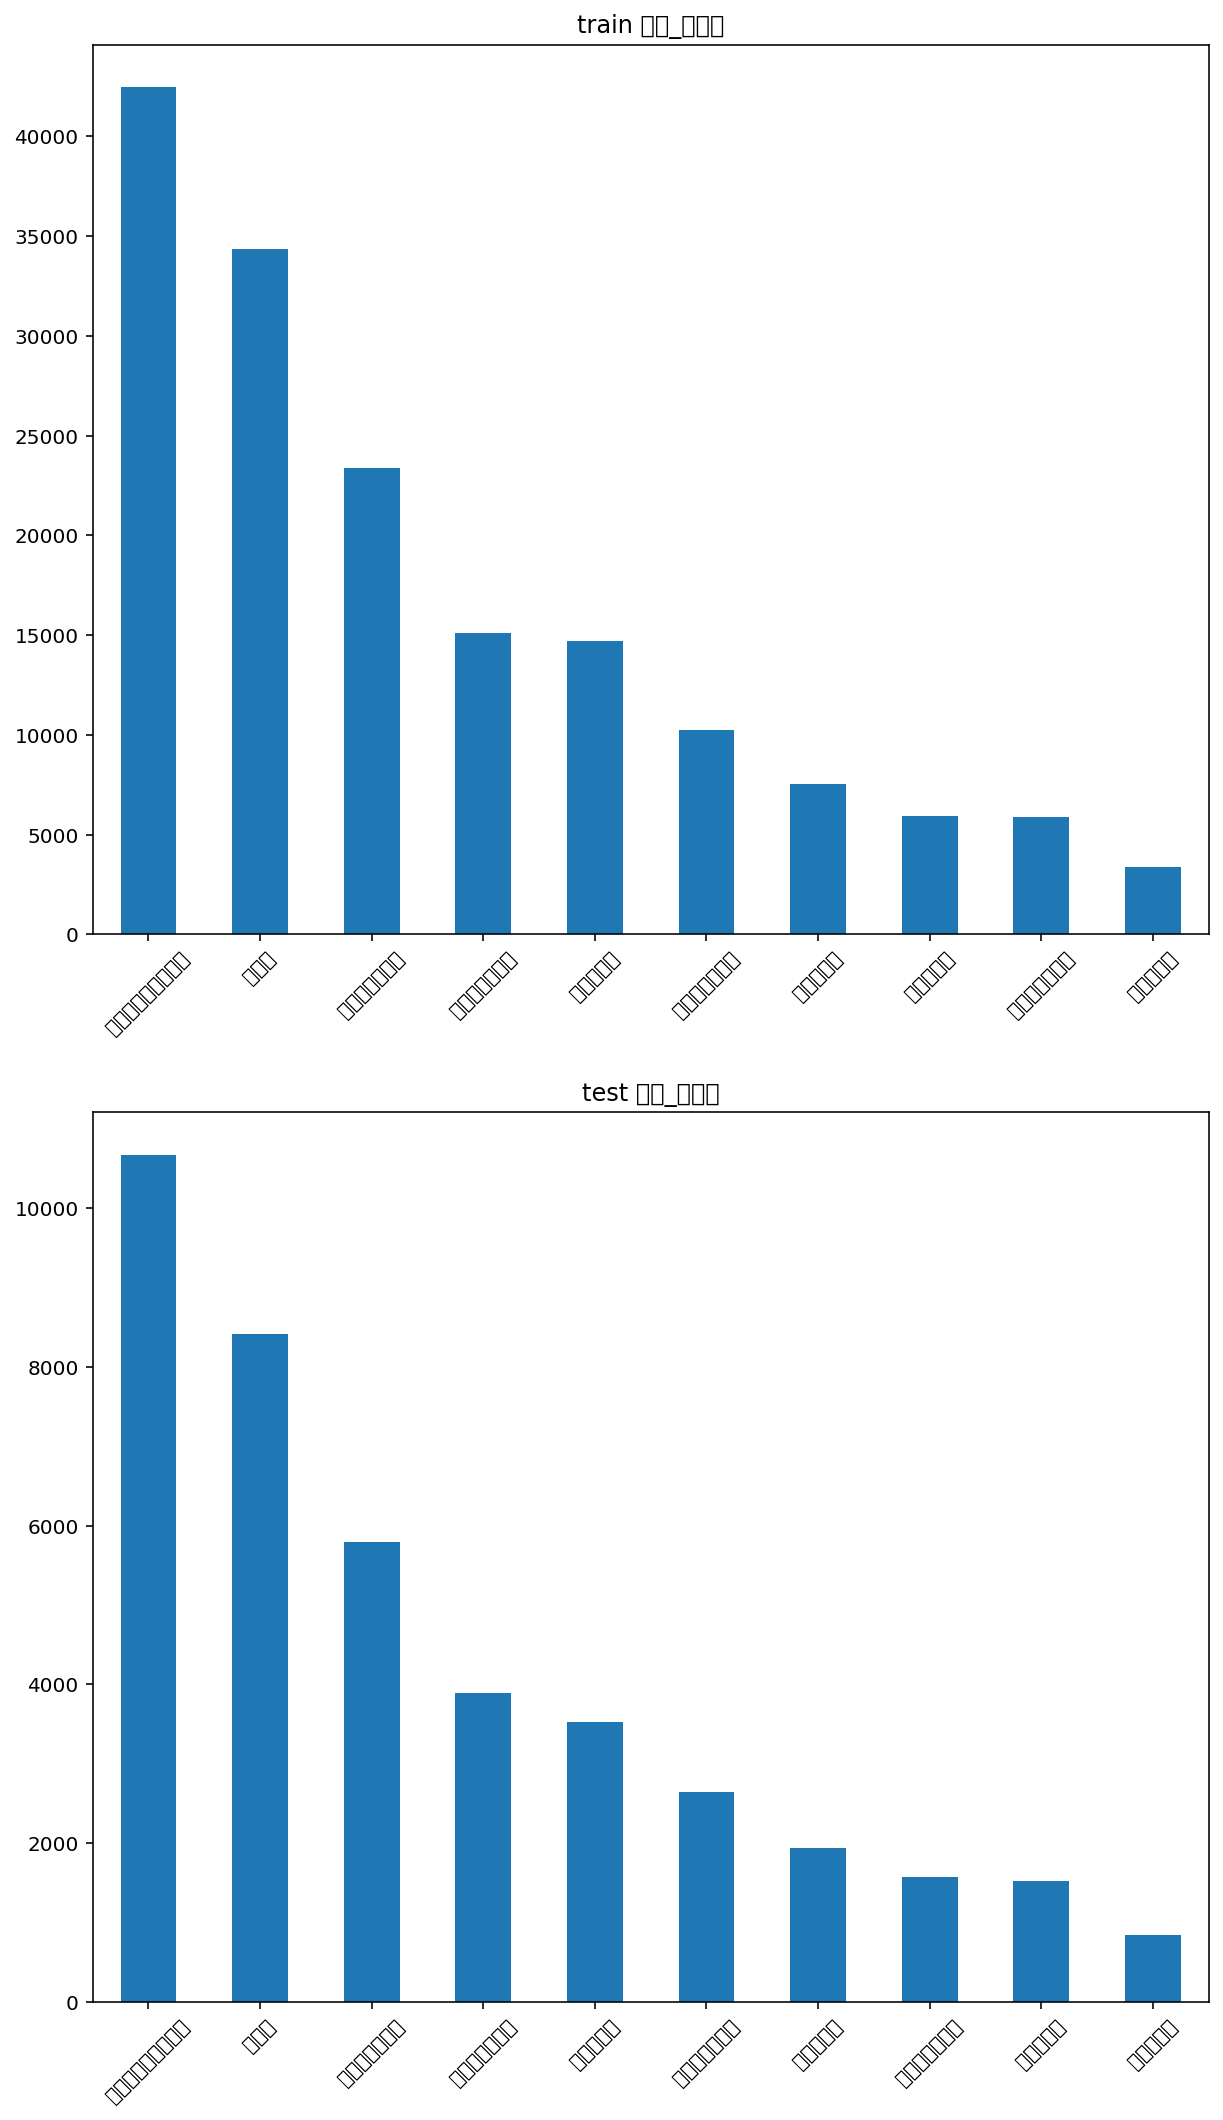

In [45]:
# 사업_부처별 분포 분석
fig, axs = plt.subplots(2,1,figsize=(10,18))
df_train.사업_부처명.value_counts()[:10].plot.bar(rot=45, ax = axs[0], title = "train 사업_부처별")
df_test.사업_부처명.value_counts()[:10].plot.bar(rot=45, ax = axs[1], title = "test 사업_부처별")

In [34]:
target_columns = ['과제명','요약문_한글키워드']

train_texts = df_train[target_columns]
test_texts = df_test[target_columns]

def visualize_train_length(train, target_columns) :
    plt.figure(figsize = (12,8)) 
    for i, column in enumerate(target_columns):
        text_len = [len(s.split()) for s in train[column]]

        display('='*50)
        display(f'{column} 최소 길이 : {np.min(text_len)}')
        display(f'{column} 25% 길이 : {np.quantile(text_len,0.25)}')
        display(f'{column} 최대 길이 : {np.max(text_len)}')
        display(f'{column} 75% 길이 : {np.quantile(text_len,0.75)}')
        display(f'{column} 평균 길이 : {np.mean(text_len)}')

        plt.subplot(2,3,i+1)
        plt.boxplot(text_len)
        plt.title(column, fontproperties=fontprop)


        plt.title(column)

        plt.subplot(2,3,i+4)
        plt.hist(text_len, bins=100)
        plt.xlabel('샘플의 길이', fontproperties=fontprop)
        plt.ylabel('샘플의 수', fontproperties=fontprop)

    plt.show()


'=================================================='

'과제명 최소 길이 : 1'

'과제명 25% 길이 : 6.0'

'과제명 최대 길이 : 41'

'과제명 75% 길이 : 10.0'

'과제명 평균 길이 : 8.436960712318708'

'=================================================='

'요약문_한글키워드 최소 길이 : 1'

'요약문_한글키워드 25% 길이 : 1.0'

'요약문_한글키워드 최대 길이 : 55'

'요약문_한글키워드 75% 길이 : 6.0'

'요약문_한글키워드 평균 길이 : 4.152922480264365'

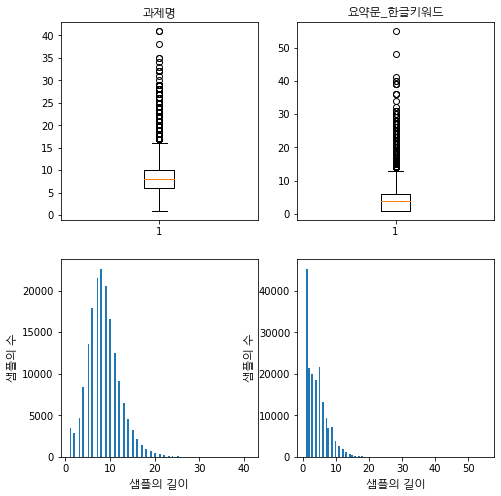

In [35]:
visualize_train_length(train_texts, target_columns)

# 데이터 학습

In [15]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=3)

In [16]:
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\
model_name = "Kobert_classifier"
checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

In [17]:
# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

Kobert_classifier -- Folder already exists 



In [19]:
KoBERT = build_classifier_model()
KoBERT.compile(optimizer=Adam(lr=1e-4),loss="categorical_crossentropy",metrics=["accuracy"])

In [20]:
history = KoBERT.fit(x_train,y_train,validation_split = 0.2,epochs=100, batch_size=32,  callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
   2/4358 [..............................] - ETA: 8:17 - loss: 3.7687 - accuracy: 0.0312       

2022-11-02 07:07:27.012955: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4358/4358 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.8633
Epoch 1: val_accuracy improved from -inf to 0.87754, saving model to Kobert_classifier/weights.h5
4358/4358 [==============================] - 610s 138ms/step - loss: 0.5286 - accuracy: 0.8633 - val_loss: 0.3991 - val_accuracy: 0.8775
Epoch 2/100
4358/4358 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8949
Epoch 2: val_accuracy improved from 0.87754 to 0.88859, saving model to Kobert_classifier/weights.h5
4358/4358 [==============================] - 601s 138ms/step - loss: 0.3433 - accuracy: 0.8949 - val_loss: 0.3570 - val_accuracy: 0.8886
Epoch 3/100
4358/4358 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.9118
Epoch 3: val_accuracy did not improve from 0.88859
4358/4358 [==============================] - 602s 138ms/step - loss: 0.2782 - accuracy: 0.9118 - val_loss: 0.3589 - val_accuracy: 0.8857
Epoch 4/100
4358/4358 [==============================]

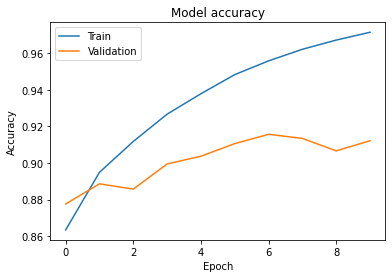

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

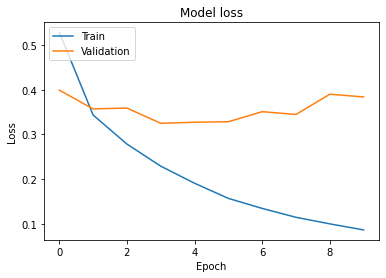

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
x_test = df_test["사업명"] + " " + df_test["과제명"] + " " + df_test["요약문_연구목표"] + " " + df_test["요약문_연구내용"] + " " + df_test["요약문_기대효과"] + " " + df_test["요약문_한글키워드"]

In [24]:
y_pred = KoBERT.predict(x_test)

1362/1362 [==============================] - 114s 83ms/step


In [25]:
df_submission = pd.read_csv("./sample_submission.csv")
y_pred_recovery = np.argmax(y_pred, axis=1).reshape(-1,)

In [26]:
df_submission["label"] = y_pred_recovery
df_submission.to_csv("./Kobert_result_2.csv", index=False)

In [27]:
KoBERT.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer_5 (KerasLayer)     {'input_mask': (Non  0           ['input_text[0][0]']             
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                      
                                                                                                  
 keras_layer_6 (KerasLayer)     {'encoder_outputs':  27803904    ['keras_layer_5[0][0]',    